# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 2. Классификация при помощи CNN. 

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим? 

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import wandb
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

In [2]:
@dataclass
class Config:
    batch_size: int = 64
    dataset: str = "CIFAR10"
    lr: float = 0.1
    momentum: float = 0.9
    n_epochs: int = 20

In [3]:
config = Config()

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [4]:
# Для тру нормализации
# mean = [0.4914, 0.4822, 0.4465]
# std = [0.2470, 0.2435, 0.2616]
# Тут взяты значения как в одном из туториалов пайторча :)


def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            # Переводим цвета пикселей в отрезок [-1, 1]
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        ]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(
        root="./data", train=True, download=True, transform=transform_train
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data", train=False, download=True, transform=transform_test
    )

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(
        np.arange(len(trainvalset)), test_size=0.3, shuffle=True, random_state=0
    )
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
    )
    val_loader = torch.utils.data.DataLoader(
        valset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
    )
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
    )

    return train_loader, val_loader, test_loader

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=config.batch_size, transform_train=transform
)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5632443].


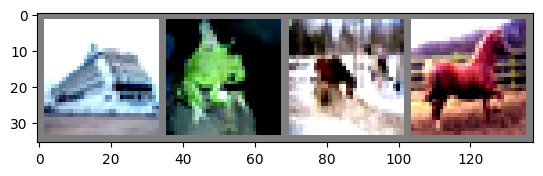

ship frog horse horse


In [6]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры, похожей на ResNet. Обратите внимание, это не ResNet 1 в 1.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [7]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        in_channels = 3
        hidden_dim = 32
        kerner_size = 3
        padding = 1
        
        self.base = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kerner_size, padding=padding),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, kerner_size, padding=padding),
            nn.BatchNorm2d(hidden_dim),
        )
        self.skip = nn.Conv2d(in_channels, hidden_dim, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.head = nn.Sequential(
            nn.AvgPool2d(8),
            nn.Flatten(),
            nn.Linear(hidden_dim * 4 * 4, n_classes)
        )
        

    def forward(self, x):
        out = self.base(x)
        skipped = self.skip(x)
        out += skipped
        out = self.relu(out)
        out = self.head(out)

        return out

In [8]:
net = BasicBlockNet()
net

BasicBlockNet(
  (base): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (skip): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (head): Sequential(
    (0): AvgPool2d(kernel_size=8, stride=8, padding=0)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)

Проверим, что выход сети имеет корректную размерность:

In [13]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [10]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [11]:
def test(model: nn.Module, loader: DataLoader, device: torch.device = 'cuda') -> tuple[float, float]:
    loss_log = []
    acc_log = []
    model.eval()

    with torch.no_grad():
        for data, target in tqdm(loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)
            
            loss_log.append(loss.item())
            acc_log.extend((torch.argmax(output, dim=1) == target).cpu().numpy().tolist())

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model: nn.Module, optimizer: optim.Optimizer, train_loader: DataLoader, scheduler=None, scheduler_step_per_batch: bool = False, device: torch.device = 'cuda') -> tuple[float, float]:
    loss_log = []
    acc_log = []
    model.train()

    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        if scheduler is not None and scheduler_step_per_batch:
            scheduler.step()
        
        loss_log.append(loss.item())
        acc_log.extend((torch.argmax(output, dim=1) == target).cpu().numpy().tolist())

    return loss_log, acc_log


def train(model: nn.Module, optimizer: optim.Optimizer, n_epochs: int, train_loader: DataLoader, val_loader: DataLoader, scheduler=None, scheduler_step_per_batch: bool = False, device: torch.device = 'cuda', wandb_run_name: str = None):
    
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    
    if wandb_run_name is not None:
        wandb.init(
            project="dl-hw-2", 
            name=wandb_run_name,
            config=config.__dict__,
        )
    
    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader, device=device, scheduler=scheduler)
        val_loss, val_acc = test(model, val_loader, device=device)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if wandb_run_name is not None:
            wandb.log({'train loss': np.mean(train_loss)}, step=epoch)
            wandb.log({'train accuracy': np.mean(train_acc) * 100}, step=epoch)
            wandb.log({'val loss': np.mean(val_loss)}, step=epoch)
            wandb.log({'val accuracy': np.mean(val_acc) * 100}, step=epoch)
        
        if scheduler is not None and not scheduler_step_per_batch:
            scheduler.step()

    if wandb_run_name is not None:
        wandb.finish()
        
    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [40]:
optimizer = optim.SGD(net.parameters(), lr=config.lr, momentum=config.momentum)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, config.n_epochs, train_loader, val_loader, wandb_run_name='basic_block_net', device=device
)

train accuracy,▁▅▇██
train loss,█▄▂▁▁
val accuracy,▁▆▇██
val loss,█▃▂▂▁
train accuracy,66.14286
train loss,0.97519
val accuracy,64.54
val loss,1.00562


  0%|          | 0/547 [00:08<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 0
 train loss: 0.9371145161675797, train acc: 0.6736857142857143
 val loss: 0.9684486056895967, val acc: 0.6665333333333333



  0%|          | 0/547 [00:08<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 1
 train loss: 0.9184855553960015, train acc: 0.6810285714285714
 val loss: 0.9370178915084677, val acc: 0.6767333333333333



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 2
 train loss: 0.90082228347196, train acc: 0.6870285714285714
 val loss: 0.9451924065326123, val acc: 0.6774



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 3
 train loss: 0.8735212378571631, train acc: 0.6964
 val loss: 0.9533722575674666, val acc: 0.6708



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 4
 train loss: 0.8584099441930189, train acc: 0.7020571428571428
 val loss: 0.9411911576352221, val acc: 0.678



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 5
 train loss: 0.8493609130382538, train acc: 0.7039142857142857
 val loss: 0.8929777464968093, val acc: 0.6930666666666667



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 6
 train loss: 0.8288603161871978, train acc: 0.7130857142857143
 val loss: 0.9342073217351385, val acc: 0.6796666666666666



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 7
 train loss: 0.8202338016011379, train acc: 0.7161142857142857
 val loss: 0.9083311841842976, val acc: 0.6914



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 8
 train loss: 0.8132966994367526, train acc: 0.7187714285714286
 val loss: 0.9390520935362958, val acc: 0.678



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 9
 train loss: 0.7985438041974683, train acc: 0.7226285714285714
 val loss: 0.9127552727435497, val acc: 0.6932



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 10
 train loss: 0.7865499271662187, train acc: 0.7285142857142857
 val loss: 0.8811555735608365, val acc: 0.6974



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 11
 train loss: 0.7783211234827582, train acc: 0.7289142857142857
 val loss: 0.9129151037398805, val acc: 0.6888666666666666



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:08<?, ?it/s]

Epoch 12
 train loss: 0.768386272832724, train acc: 0.7330571428571429
 val loss: 0.9118989721257635, val acc: 0.6906



  0%|          | 0/547 [00:08<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 13
 train loss: 0.7645261323103303, train acc: 0.7347714285714285
 val loss: 0.8642814859430841, val acc: 0.702



  0%|          | 0/547 [00:08<?, ?it/s]

  0%|          | 0/235 [00:08<?, ?it/s]

Epoch 14
 train loss: 0.7549249608839234, train acc: 0.7359142857142857
 val loss: 0.8803536981978315, val acc: 0.7029333333333333



  0%|          | 0/547 [00:08<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 15
 train loss: 0.7498483558132618, train acc: 0.7389428571428571
 val loss: 0.8780771495179928, val acc: 0.7028666666666666



  0%|          | 0/547 [00:08<?, ?it/s]

  0%|          | 0/235 [00:08<?, ?it/s]

Epoch 16
 train loss: 0.7404679939341502, train acc: 0.7420857142857142
 val loss: 0.841692915875861, val acc: 0.7151333333333333



  0%|          | 0/547 [00:08<?, ?it/s]

  0%|          | 0/235 [00:08<?, ?it/s]

Epoch 17
 train loss: 0.7335122337180038, train acc: 0.7465714285714286
 val loss: 0.8588134806206886, val acc: 0.7045333333333333



  0%|          | 0/547 [00:08<?, ?it/s]

  0%|          | 0/235 [00:08<?, ?it/s]

Epoch 18
 train loss: 0.7261087095170832, train acc: 0.7466857142857143
 val loss: 0.8764638827202168, val acc: 0.7035333333333333



  0%|          | 0/547 [00:08<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 19
 train loss: 0.723210799519715, train acc: 0.7476857142857143
 val loss: 0.8930215901516854, val acc: 0.6984666666666667



train accuracy,▁▂▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇███
train loss,█▇▇▆▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁
val accuracy,▁▂▃▂▃▅▃▅▃▅▅▄▄▆▆▆█▆▆▆
val loss,█▆▇▇▆▄▆▅▆▅▃▅▅▂▃▃▁▂▃▄
train accuracy,74.76857
train loss,0.72321
val accuracy,69.84667
val loss,0.89302


Посчитайте точность на тестовой выборке:

In [41]:
_, test_acc = test(net, test_loader, device='cuda')
print(f"Test Accuracy: {test_acc * 100:.2f}%")

  0%|          | 0/157 [00:06<?, ?it/s]

Test Accuracy: 69.55%


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [75]:
n_full_batches = len(train_acc_log) // config.batch_size
train_acc_batches = np.array(train_acc_log[:n_full_batches * config.batch_size]).reshape(n_full_batches, config.batch_size)
train_acc_means = train_acc_batches.mean(axis=1) # взял среднее по батчам

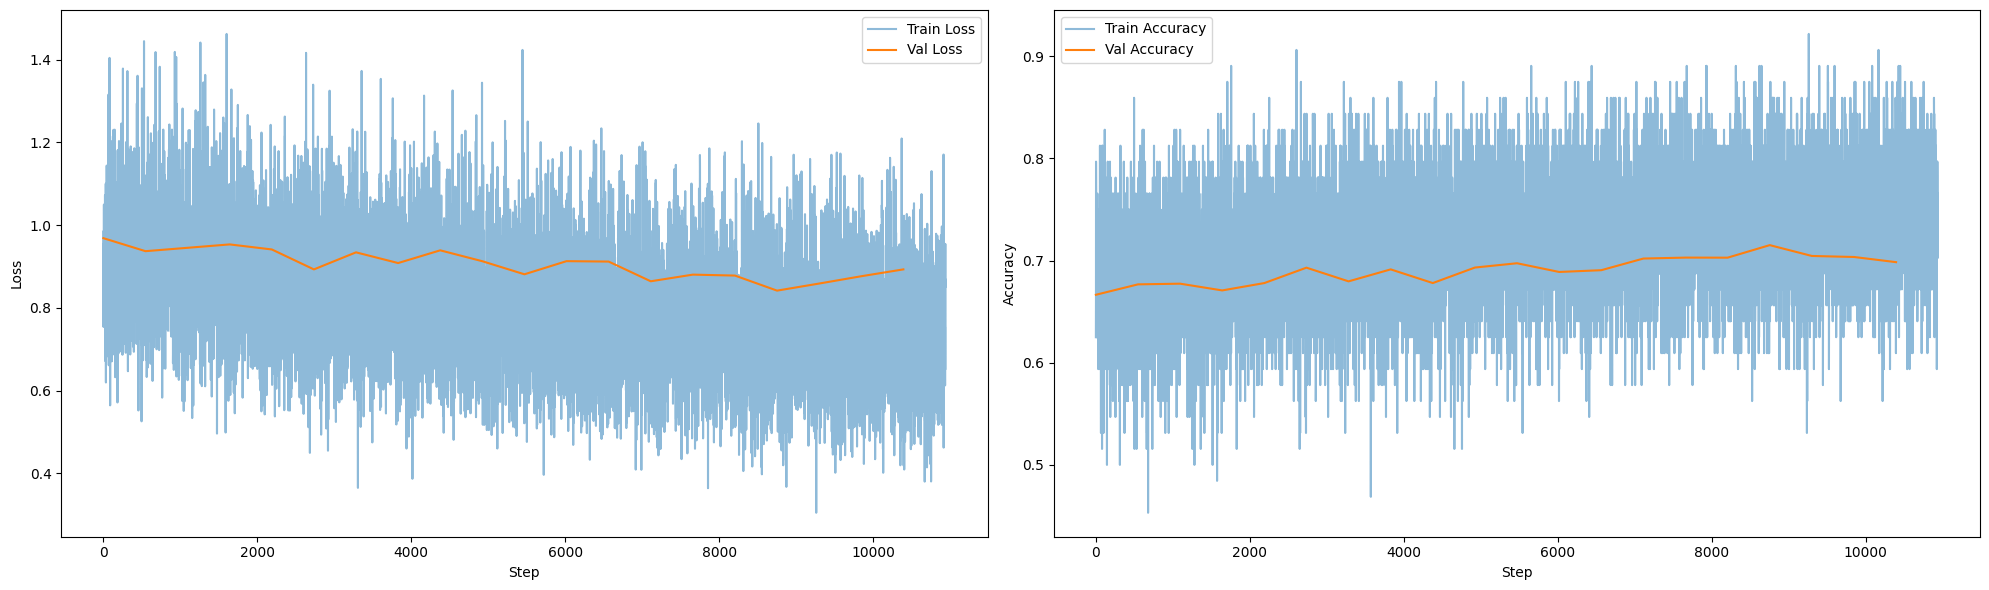

In [74]:
train_steps = np.arange(len(train_loss_log))
val_steps = np.arange(len(val_loss_log)) * (len(train_loss_log) // len(val_loss_log))

plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(train_steps, train_loss_log, label='Train Loss', alpha=0.5)
plt.plot(val_steps, val_loss_log, label='Val Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_steps[:len(train_acc_means)], train_acc_means, label='Train Accuracy', alpha=0.5) # пришлось обрезать шаги из-за отброшенных неполных батчей
plt.plot(val_steps, val_acc_log, label='Val Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Вывод
На тесте получилось `accuracy=69.55%`. Но по графикам обучения на валидационной выборке видно как колбасило модель, судя по всему, она так и не смогла попасть в глобальный минимум. \
Графики строил в wandb, сюда не стал пока прикладывать.

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [76]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=config.lr, momentum=config.momentum, fused=True)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, config.n_epochs, train_loader, val_loader, scheduler, device=device, wandb_run_name='basic_block_net_multistep'
)

  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 0
 train loss: 1.492598429022585, train acc: 0.46337142857142855
 val loss: 1.287710588282727, val acc: 0.5512666666666667



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 1
 train loss: 1.1789086590737268, train acc: 0.586
 val loss: 1.1339171741871124, val acc: 0.5929333333333333



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 2
 train loss: 1.051310381462195, train acc: 0.6337142857142857
 val loss: 1.0393274451823944, val acc: 0.6348



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 3
 train loss: 0.9851221594775617, train acc: 0.6575428571428571
 val loss: 0.9927485615649122, val acc: 0.656



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 4
 train loss: 0.9511649142235681, train acc: 0.6728
 val loss: 0.9743716633066218, val acc: 0.6667333333333333



  0%|          | 0/547 [00:08<?, ?it/s]

  0%|          | 0/235 [00:08<?, ?it/s]

Epoch 5
 train loss: 0.9247824871125997, train acc: 0.6787142857142857
 val loss: 0.9972100744856165, val acc: 0.6544666666666666



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 6
 train loss: 0.9008172004052882, train acc: 0.6889142857142857
 val loss: 0.9676742924020646, val acc: 0.6664



  0%|          | 0/547 [00:08<?, ?it/s]

  0%|          | 0/235 [00:08<?, ?it/s]

Epoch 7
 train loss: 0.8814018099573891, train acc: 0.6962857142857143
 val loss: 0.9414674096919121, val acc: 0.6740666666666667



  0%|          | 0/547 [00:08<?, ?it/s]

  0%|          | 0/235 [00:08<?, ?it/s]

Epoch 8
 train loss: 0.8633269907351604, train acc: 0.7033142857142857
 val loss: 0.8924801877204408, val acc: 0.6901333333333334



  0%|          | 0/547 [00:08<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 9
 train loss: 0.8479038618055514, train acc: 0.7084
 val loss: 0.9290213939991403, val acc: 0.6772666666666667



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 10
 train loss: 0.7440383378177936, train acc: 0.7438
 val loss: 0.8261093645653826, val acc: 0.7147333333333333



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 11
 train loss: 0.7244067048786763, train acc: 0.7514571428571428
 val loss: 0.8304726019818732, val acc: 0.7150666666666666



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 12
 train loss: 0.7194939512875224, train acc: 0.7536571428571428
 val loss: 0.8248498453738842, val acc: 0.7153333333333334



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 13
 train loss: 0.7129036775999574, train acc: 0.7557714285714285
 val loss: 0.8195254315721228, val acc: 0.718



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 14
 train loss: 0.7096877112793966, train acc: 0.7572857142857143
 val loss: 0.8200054267619519, val acc: 0.7180666666666666



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 15
 train loss: 0.6941262445458546, train acc: 0.7624857142857143
 val loss: 0.8127916583355437, val acc: 0.7214666666666667



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 16
 train loss: 0.6912721505548662, train acc: 0.7634285714285715
 val loss: 0.8124660216747446, val acc: 0.721



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 17
 train loss: 0.6907350024313987, train acc: 0.7624
 val loss: 0.8128691316919124, val acc: 0.7203333333333334



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 18
 train loss: 0.6893750025432768, train acc: 0.7649714285714285
 val loss: 0.8114044640926604, val acc: 0.7212



  0%|          | 0/547 [00:17<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 19
 train loss: 0.6909200843879902, train acc: 0.7644857142857143
 val loss: 0.8110451639966761, val acc: 0.7212666666666666



train accuracy,▁▄▅▆▆▆▆▆▇▇██████████
train loss,█▅▄▄▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁
val accuracy,▁▃▄▅▆▅▆▆▇▆██████████
val loss,█▆▄▄▃▄▃▃▂▃▁▁▁▁▁▁▁▁▁▁
train accuracy,76.44857
train loss,0.69092
val accuracy,72.12667
val loss,0.81105


Посчитайте точность на тестовой выборке:

In [77]:
_, test_acc = test(net, test_loader, device=device)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

  0%|          | 0/157 [00:06<?, ?it/s]

Test Accuracy: 72.04%


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [81]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=config.momentum, fused=True)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, config.n_epochs, train_loader, val_loader, device=device
)

  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 0
 train loss: 1.7817781851975967, train acc: 0.376
 val loss: 1.5721621584385, val acc: 0.452



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 1
 train loss: 1.4986053574455722, train acc: 0.4735714285714286
 val loss: 1.4134525349799623, val acc: 0.5044666666666666



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 2
 train loss: 1.3852520823696632, train acc: 0.5161428571428571
 val loss: 1.3411692193213929, val acc: 0.5272666666666667



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 3
 train loss: 1.318256766312301, train acc: 0.5370571428571429
 val loss: 1.2872238483834775, val acc: 0.5468666666666666



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 4
 train loss: 1.2696083195684598, train acc: 0.554
 val loss: 1.248345909220107, val acc: 0.5636



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 5
 train loss: 1.221973085970068, train acc: 0.5718857142857143
 val loss: 1.2107719073904322, val acc: 0.5798



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 6
 train loss: 1.186916551598683, train acc: 0.5862285714285714
 val loss: 1.1737845124082362, val acc: 0.5886



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 7
 train loss: 1.1532816870556888, train acc: 0.5974857142857143
 val loss: 1.13866886407771, val acc: 0.6000666666666666



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 8
 train loss: 1.1262921147198302, train acc: 0.6051714285714286
 val loss: 1.1215706599519608, val acc: 0.6085333333333334



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 9
 train loss: 1.101242619415088, train acc: 0.6158
 val loss: 1.0922952657050276, val acc: 0.6198



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 10
 train loss: 1.0774683811764831, train acc: 0.6252857142857143
 val loss: 1.090587088909555, val acc: 0.6177333333333334



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 11
 train loss: 1.052677985954982, train acc: 0.6360857142857143
 val loss: 1.0373432610897309, val acc: 0.6442666666666667



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 12
 train loss: 1.0310617120871814, train acc: 0.6430571428571429
 val loss: 1.049917631707293, val acc: 0.6330666666666667



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 13
 train loss: 1.0114888229579333, train acc: 0.6504
 val loss: 1.0084221512713332, val acc: 0.6504



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 14
 train loss: 0.9962291058282312, train acc: 0.6542857142857142
 val loss: 0.999965748888381, val acc: 0.6533333333333333



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 15
 train loss: 0.9787925153807269, train acc: 0.6614857142857142
 val loss: 0.973858986763244, val acc: 0.6617333333333333



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 16
 train loss: 0.9594808348354081, train acc: 0.6703714285714286
 val loss: 0.9698940563709177, val acc: 0.6654



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 17
 train loss: 0.9489450746741983, train acc: 0.6709428571428572
 val loss: 0.9595386177935499, val acc: 0.6676666666666666



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 18
 train loss: 0.9411162962861209, train acc: 0.6751714285714285
 val loss: 0.9431920391448001, val acc: 0.6726666666666666



  0%|          | 0/547 [00:07<?, ?it/s]

  0%|          | 0/235 [00:07<?, ?it/s]

Epoch 19
 train loss: 0.9301345365792786, train acc: 0.6772571428571429
 val loss: 0.9413242426324397, val acc: 0.6771333333333334



**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [12]:
n_steps = config.n_epochs*len(train_loader)

In [ ]:
one_cycle_lr_net = BasicBlockNet().to(device)
optimizer = optim.SGD(one_cycle_lr_net.parameters(), lr=config.lr, momentum=config.momentum, fused=True)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, div_factor=10, total_steps=n_steps)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    one_cycle_lr_net, optimizer, config.n_epochs, train_loader, val_loader, scheduler, scheduler_step_per_batch=True, device=device, wandb_run_name='basic_block_net_one_cycle_lr'
)

In [14]:
print(f"Точность на валидации с OneCycleLR: {np.max(val_acc_log) * 100:.2f}")

Точность на валидации с OneCycleLR: 72.37


In [ ]:
basic_block_net_cosine_lr = BasicBlockNet().to(device)
optimizer = optim.SGD(basic_block_net_cosine_lr.parameters(), lr=config.lr, momentum=config.momentum, fused=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_steps)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    basic_block_net_cosine_lr, optimizer, config.n_epochs, train_loader, val_loader, scheduler, scheduler_step_per_batch=True, device=device, wandb_run_name='basic_block_net_cosine_lr'
)

In [16]:
print(f"Точность на валидации с CosineAnnealingLR: {np.max(val_acc_log) * 100:.2f}")

Точность на валидации с CosineAnnealingLR: 70.69


Посмотрим на качество на тестовой выборке с использованием `OneCycleLR`

In [21]:
_, test_acc = test(one_cycle_lr_net, test_loader, device=device)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

  0%|          | 0/157 [00:06<?, ?it/s]

Test Accuracy: 71.44%


Your answers here:

1. С `MultiStepLR` качество на тесте лучше, чем с константным learning rate: `72%` vs `67%`
2. Я использовал `OneCycleLR` - меняет lr раз в батч, сначала повышает до max_lr, потом плавно уменшает. В моём случае начичает с `0.1/10=0.01` и доходит до `0.1`, потом идет вниз. В целом, показал хорошее качество = `72.37%`, но можно попробовать уменьшить начальный lr.
3. Использовал `CosineAnnealingLR` - плавно уменьшает lr по косинусной кривой, так же сделал уменьшение раз в батч, хотя можно и раз в эпоху. Показал качество хуже = `70.69%`. Можно было взять cosine c warmup, скорее всего качество было бы не хуже, чем у `OneCycleLR`.

На тесте `OneCycleLR` показал качество `71.44%`

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.557913].


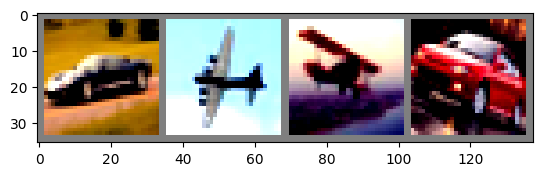

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.557913].


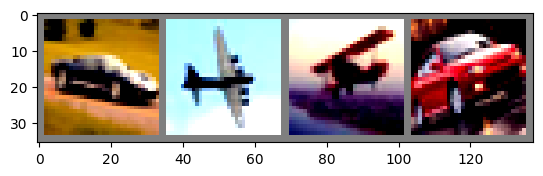

In [18]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, config.n_epochs, train_loader, val_loader, scheduler, device=device
)

Посчитайте точность на тестовой выборке:

In [23]:
_, test_acc = test(net, test_loader, device=device)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

  0%|          | 0/157 [00:06<?, ?it/s]

Test Accuracy: 61.20%


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        transforms.RandomErasing(p=0.5),
    ]
)


train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=config.batch_size, transform_train=transform
)

one_cycle_lr_net = BasicBlockNet().to(device)
optimizer = optim.SGD(one_cycle_lr_net.parameters(), lr=config.lr, momentum=config.momentum, fused=True)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, div_factor=10, total_steps=n_steps)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    one_cycle_lr_net, optimizer, config.n_epochs, train_loader, val_loader, scheduler, scheduler_step_per_batch=True, device=device,
)

In [40]:
print(f"Точность на валидации с Erasing трансформом: {np.max(val_acc_log) * 100:.2f}%")

Точность на валидации с Erasing трансформом: 68.62%


In [ ]:
transform = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ]
)


train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=config.batch_size, transform_train=transform
)

one_cycle_lr_net = BasicBlockNet().to(device)
optimizer = optim.SGD(one_cycle_lr_net.parameters(), lr=config.lr, momentum=config.momentum, fused=True)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, div_factor=10, total_steps=n_steps)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    one_cycle_lr_net, optimizer, config.n_epochs, train_loader, val_loader, scheduler, scheduler_step_per_batch=True, device=device,
)

In [42]:
print(f"Точность на валидации с ColorJitter трансформом: {np.max(val_acc_log) * 100:.2f}%")

Точность на валидации с ColorJitter трансформом: 71.61%


In [ ]:
transform = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        transforms.RandomErasing(p=0.5),
    ]
)


train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=config.batch_size, transform_train=transform
)

one_cycle_lr_net = BasicBlockNet().to(device)
optimizer = optim.SGD(one_cycle_lr_net.parameters(), lr=config.lr, momentum=config.momentum, fused=True)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, div_factor=10, total_steps=n_steps)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    one_cycle_lr_net, optimizer, config.n_epochs, train_loader, val_loader, scheduler, scheduler_step_per_batch=True, device=device,
)

In [44]:
print(f"Точность на валидации с полным трансформом: {np.max(val_acc_log) * 100:.2f}%")

Точность на валидации с полным трансформом: 68.33%


In [45]:
_, test_acc = test(one_cycle_lr_net, test_loader, device=device)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

  0%|          | 0/157 [00:06<?, ?it/s]

Test Accuracy: 71.77%


Your answers here:
1. `RandomHorizontalFlip` - горизонтально зеркалим картинку с заданной вероятностью
2. `ColorJitter` - случайно меняет яркость, контраст, насыщенность и оттенок изображения с заданной вероятностью
3. `RandomErasing` - затирает случаный прямоугольник на изображении с заданной вероятностью

При использовании всех этих трансформаций, качество на тест увеличилось на `0.33%`, стало `71.77%`

## Бонус. Логирование в wandb (1 балл)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

Если вас смущает, что WandB грозится забанить вас, то можете разобраться с любым его аналогом и приложить ссылку на аналог.

Ссылка на репорт: https://wandb.ai/semiteplov-hse-university/dl-hw-2/reports/HW2-CNN--VmlldzoxMjMxMTQ3Mg?accessToken=f0uz6fz2ibi5qqompwghvln5zc2ktohfdrc823h5ivvaxed4cyulhnb4bmcnvcrv \
Изменить доступ к уже существующему проекту у меня не получилось, поэтому скинул ссылку на репорт.